In [1]:
import sys
sys.path.insert(0, '../Field_Ionization')
sys.path.insert(0, '../Constants')
sys.path.insert(0, '../recombination')
sys.path.insert(0, "../../../photoDAQ")
sys.path.insert(0, "../../python")
import coeffs as cf
import eBeam_v02 as eb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from diagnostics import probe
from scipy.optimize import curve_fit
import SI
import file
c = SI.lightSpeed
plt.style.use('Presentation')
figpath = '/media/keenan/Data_Storage/Google Drive/CU/PWFA/2018 Conferences/AAC/'
file.PATH = '/media/keenan/Data_Storage/Data/Double_Probe_Diagnostic/'

In [2]:
def myround(x, base=5):
    return int(base * round(float(x)/base))

In [3]:
# Electric field and ionization rate of argon from FACET II like beam. 
beamParams = eb.get_beam()
pos = eb.get_pos(beamParams, nxi = 5)
Er, dum, dum1 = eb.rad_E_field(pos, beamParams)
W_Ar1 = eb.ionization_rate(Er, 'Ar+')
W_He1 = eb.ionization_rate(Er, 'He+')

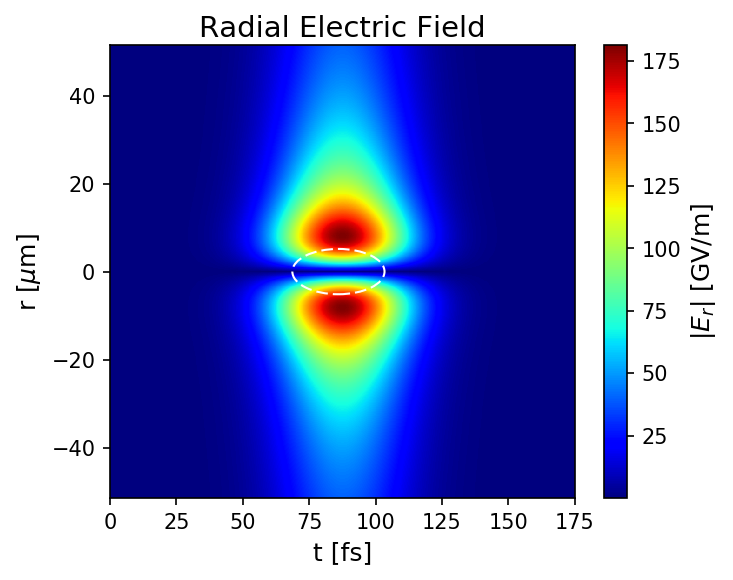

In [14]:
r = np.flipud(pos['r'][0]) * 1e6
t = (pos['xi'] * 1e15 / (beamParams['beta']*c)) -\
    (pos['xi'][0]*1e15 /(beamParams['beta']*c))
ext = [min(t), myround(max(t)), min(r), max(r)]
fig1 = plt.figure(figsize = (5,4), dpi = 150); ax1 = fig1.gca()
cen = (int(t[-1]/2), 0)
ax1.add_artist(patches.Ellipse(cen, beamParams['sigma_t']*2e15, beamParams['sigma_r'][0]*2e6, fc = 'none', \
                               ec = 'w', ls = '--'))
img1 = ax1.imshow(np.flipud(abs(Er[0])), cmap = 'jet', aspect = 'auto', extent = ext)
cbar1 = plt.colorbar(mappable = img1, ax = ax1)
cbar1.set_label(r'|$E_r$| [GV/m]')
ax1.set_xlabel('t [fs]')
ax1.set_ylabel(r'r [$\mu$m]')
ax1.set_title('Radial Electric Field')
plt.savefig('/media/keenan/Data_Storage/Google Drive/CU/PWFA/2018 Conferences/AAC/rad_E_field.svg')
plt.show()


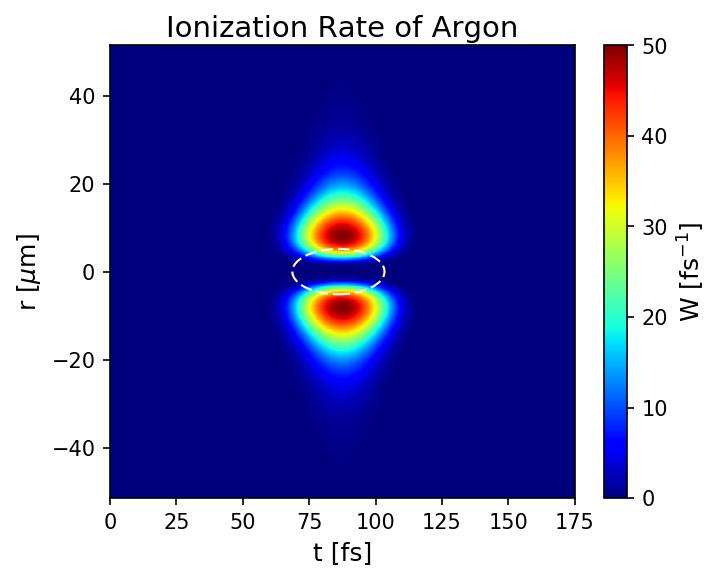

In [15]:
fig2 = plt.figure(figsize = (5,4), dpi = 150); ax2 = fig2.gca()
ax2.add_artist(patches.Ellipse(cen, beamParams['sigma_t']*2e15, beamParams['sigma_r'][0]*2e6, fc = 'none', \
                               ec = 'w', ls = '--'))
img2 = ax2.imshow(np.flipud(abs(W_Ar1[0])), cmap = 'jet', aspect = 'auto', extent = ext)
cbar2 = plt.colorbar(mappable = img2, ax = ax2)
cbar2.set_label(r'W [fs$^{-1}$]')
ax2.set_xlabel('t [fs]')
ax2.set_ylabel(r'r [$\mu$m]')
ax2.set_title('Ionization Rate of Argon')
plt.savefig('/media/keenan/Data_Storage/Google Drive/CU/PWFA/2018 Conferences/AAC/ion_rate_Ar.svg')
plt.show()

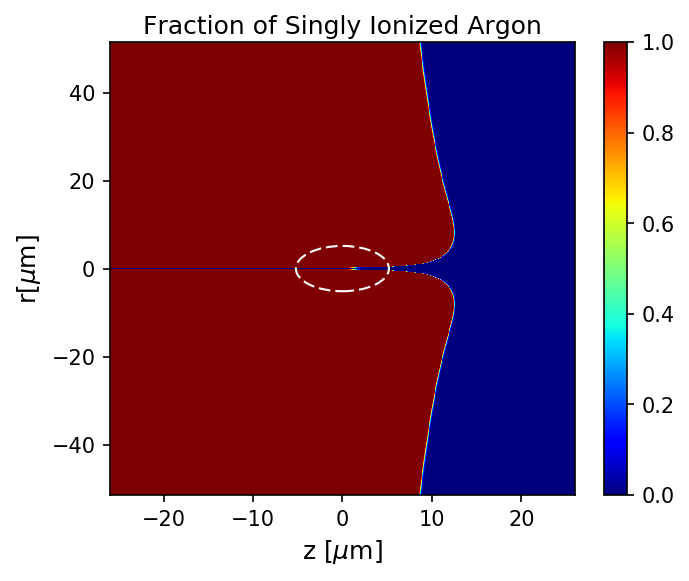

In [16]:
# Bonus Slides Argon and Helium plasma

fig = plt.figure(figsize = (5,4), dpi = 150)
ax = fig.gca()
W_int_Ar = np.fliplr(np.cumsum(W_Ar1[0], axis = 1)) * ((t[1]-t[0])*1e15)
n_rz = 1 - np.exp(-W_int_Ar)
ext = [min(pos['xi']*1e6), max(pos['xi']*1e6), min(pos['r'][0])*1e6, max(pos['r'][0])*1e6]
img = ax.imshow(n_rz, cmap = 'jet', extent = ext, aspect = 'auto')
ax.add_artist(patches.Ellipse((0,0), beamParams['sigma_z']*2e6, beamParams['sigma_r'][0]*2e6,\
                               fc = 'none', ec = 'w', ls = '--'))
ax.set_xlabel('z [$\mu$m]')
ax.set_ylabel('r[$\mu$m]')
ax.set_title('Fraction of Singly Ionized Argon', fontsize = 12)
cbar = plt.colorbar(mappable = img, ax = ax)
plt.savefig(figpath + 'ionized_Ar.svg')
plt.show()

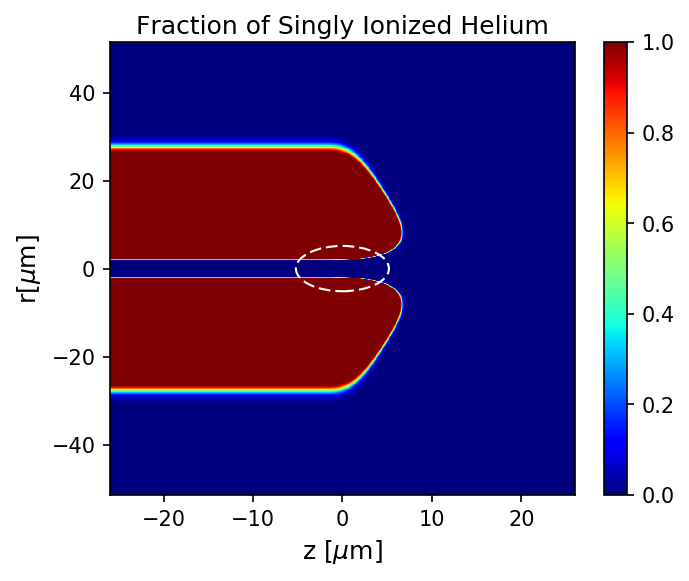

In [17]:
fig = plt.figure(figsize = (5,4), dpi = 150)
ax = fig.gca()
W_int_He = np.fliplr(np.cumsum(W_He1[0], axis = 1)) * ((t[1]-t[0])*1e15)
n_rz = 1 - np.exp(-W_int_He)
ext = [min(pos['xi']*1e6), max(pos['xi']*1e6), min(pos['r'][0])*1e6, max(pos['r'][0])*1e6]
img = ax.imshow(n_rz, cmap = 'jet', extent = ext, aspect = 'auto')
ax.add_artist(patches.Ellipse((0,0), beamParams['sigma_z']*2e6, beamParams['sigma_r'][0]*2e6,\
                               fc = 'none', ec = 'w', ls = '--'))
ax.set_xlabel('z [$\mu$m]')
ax.set_ylabel('r[$\mu$m]')
ax.set_title('Fraction of Singly Ionized Helium', fontsize = 12)
cbar = plt.colorbar(mappable = img, ax = ax)
plt.savefig(figpath + 'ionized_He.svg')
plt.show()

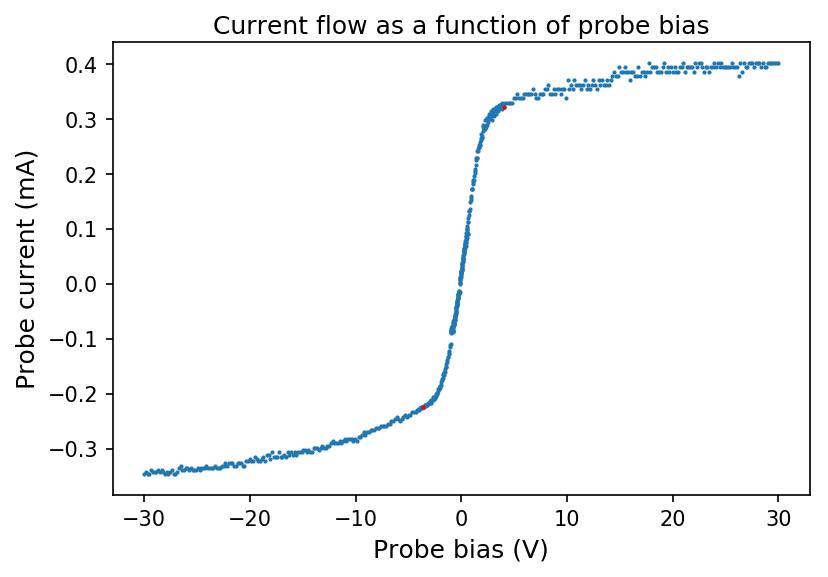

In [22]:
# Double langmuir probe diagnostic
dataSets = [1806050001, 1806050002, 1806050003, 1806050005, 1806050006, 1806050007]
sign = [0, 1, 0, 0, 1, 1]
shots = probe.get_shots(dataSets)
data, volt, time = probe.load_data(dataSets, sign, shots)
dataShifted = probe.shift_dataSets(shots, data, [0.02, 0.02, 0.02, 0.04, 0.04, 0.08], [2, 2, 0, 0, 1, 1])
timeShifted = probe.shift_time(dataSets)
# Now lets look at a couple times and see what the current/voltage looks like
ind = 70
current = -dataShifted[:, ind]/9.92 #in mA

Ip1I = 495
if ind < 70:
    Ip2I = 295 - ind
else:
    Ip2I = 225
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(volt, current, '.', linestyle='none', markerSize=2)
plt.plot(volt[Ip1I], current[Ip1I], 'r.', linestyle='none', markerSize=2)
plt.plot(volt[Ip2I], current[Ip2I], 'r.', linestyle='none', markerSize=2)
plt.title('Current flow as a function of probe bias', fontsize = 12)
plt.xlabel('Probe bias (V)', fontsize = 12)
plt.ylabel('Probe current (mA)', fontsize = 12)
plt.savefig('/media/keenan/Data_Storage/Google Drive/CU/PWFA/2018 Conferences/AAC/probe_current.svg')
plt.show()

Temperature is 0.87 eV


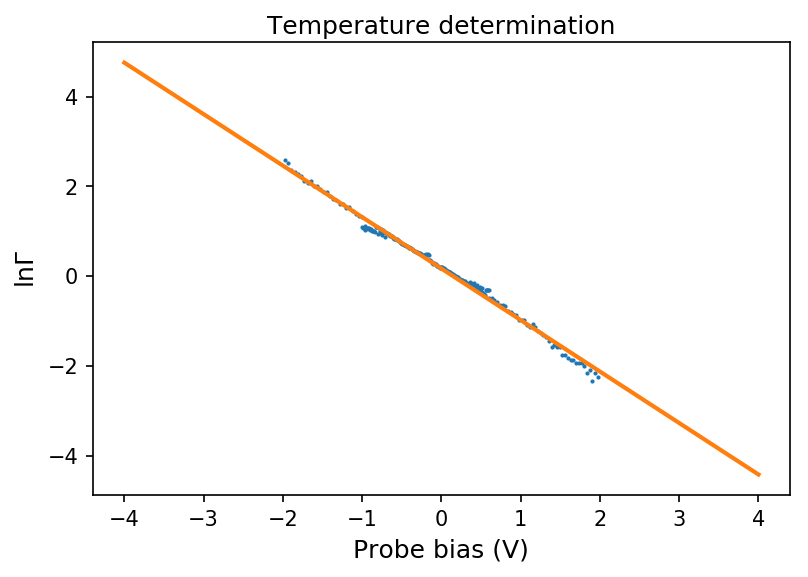

In [23]:
Ip1 = current[Ip1I]
Ip2 = -current[Ip2I]
sel = np.logical_and(current > -Ip2, current < Ip1)*np.logical_and(volt > -2, volt < 2)
Ie2 = current[sel] + Ip2
v = volt[sel]
log = np.log((Ip1+Ip2)/Ie2 - 1)

def line(x, m, b):
    return m*x + b

popt, pcov = curve_fit(line, v, log)
print('Temperature is %0.2f eV' % (-1/popt[0]))

vplot = np.linspace(-4, 4, 100)
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(v, log, '.', linestyle='none', markerSize=2)
plt.plot(vplot, line(vplot, *popt), linewidth = 2)
plt.title('Temperature determination', fontsize = 12)
plt.xlabel('Probe bias (V)', fontsize = 12)
plt.ylabel(r'$\ln \Gamma$', fontsize = 12)
plt.savefig(figpath + 'temperature_det.svg')
plt.show()

In [3]:
# Plasma recombination
n0 = 5e16; # per cc
kb_eV = SI.boltzmann * 6.242e18; 
T_eV = np.linspace(100/11600, 1.5, 10000)
T = T_eV * 11600
alpha_s = cf.simpson(T)[0] # m^6/s
alpha_s = alpha_s * 1e12; # cm^6/s
alpha_s = alpha_s * n0; # cm^3/s
alpha_hh = cf.hh(kb_eV * T, n0) # cm^3/s
alpha_g = cf.gurachev(T, n0) # cm^3/s
alpha_d = cf.desai(T, n0); # cm^3/s


t_s = 1 / (n0 * alpha_s)
t_hh = 1 / (n0 * alpha_hh)
t_g = 1 / (n0 * alpha_g)
t_d = 1 / (n0 * alpha_d)


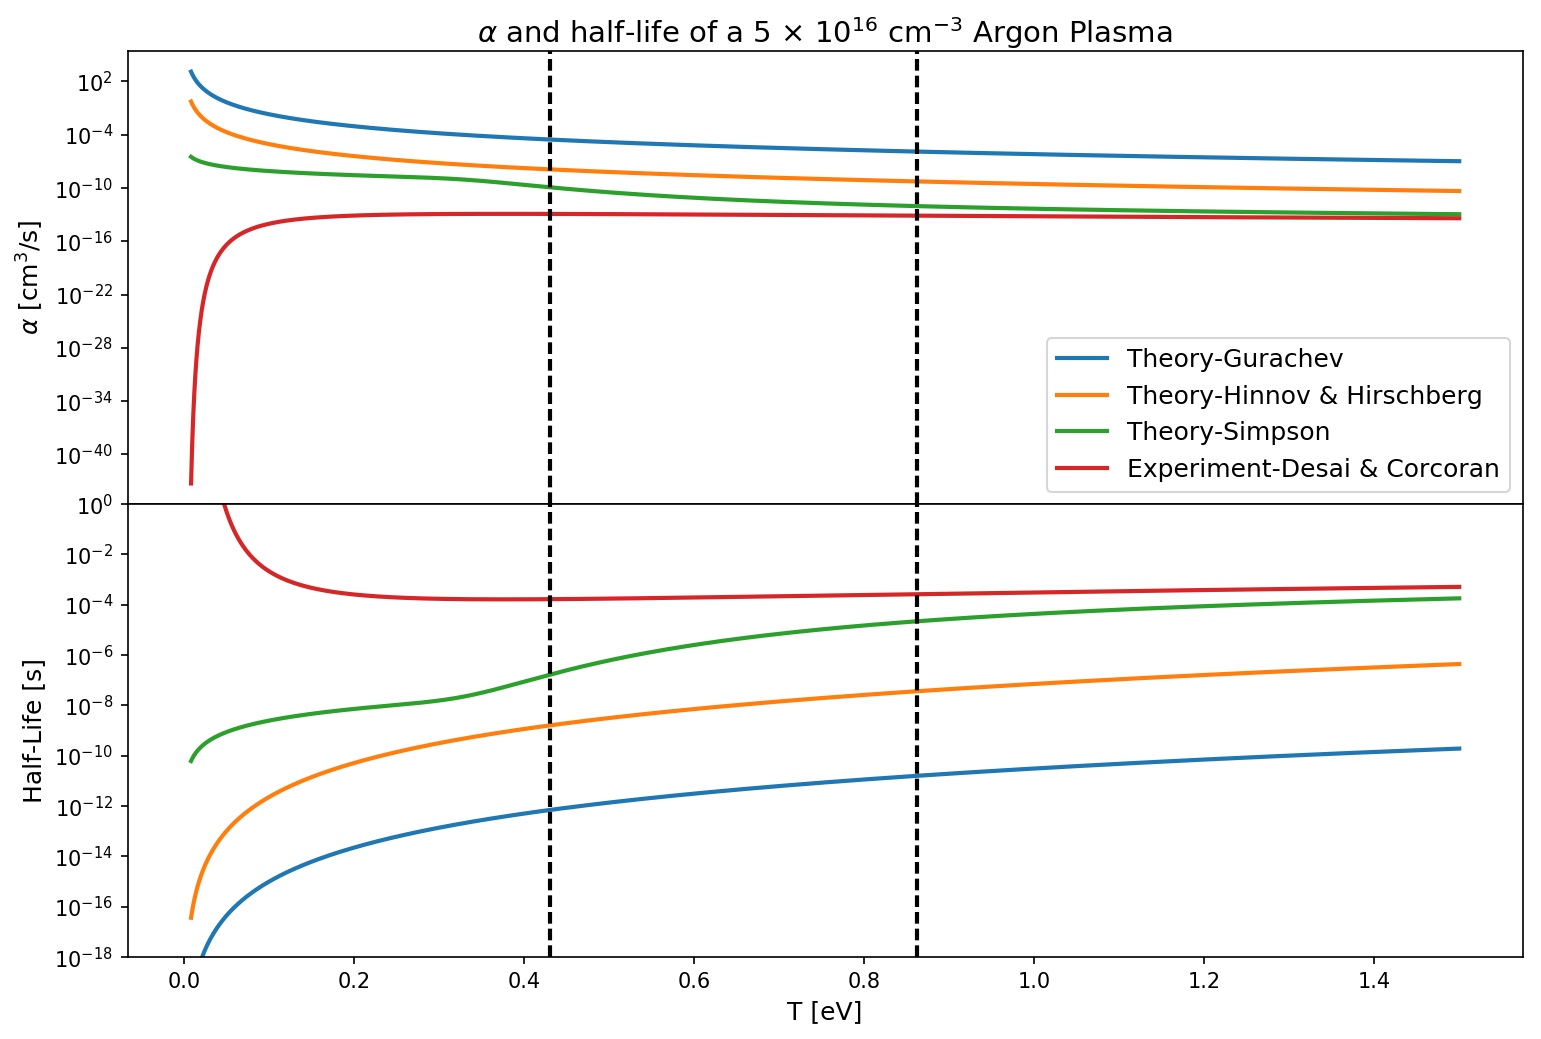

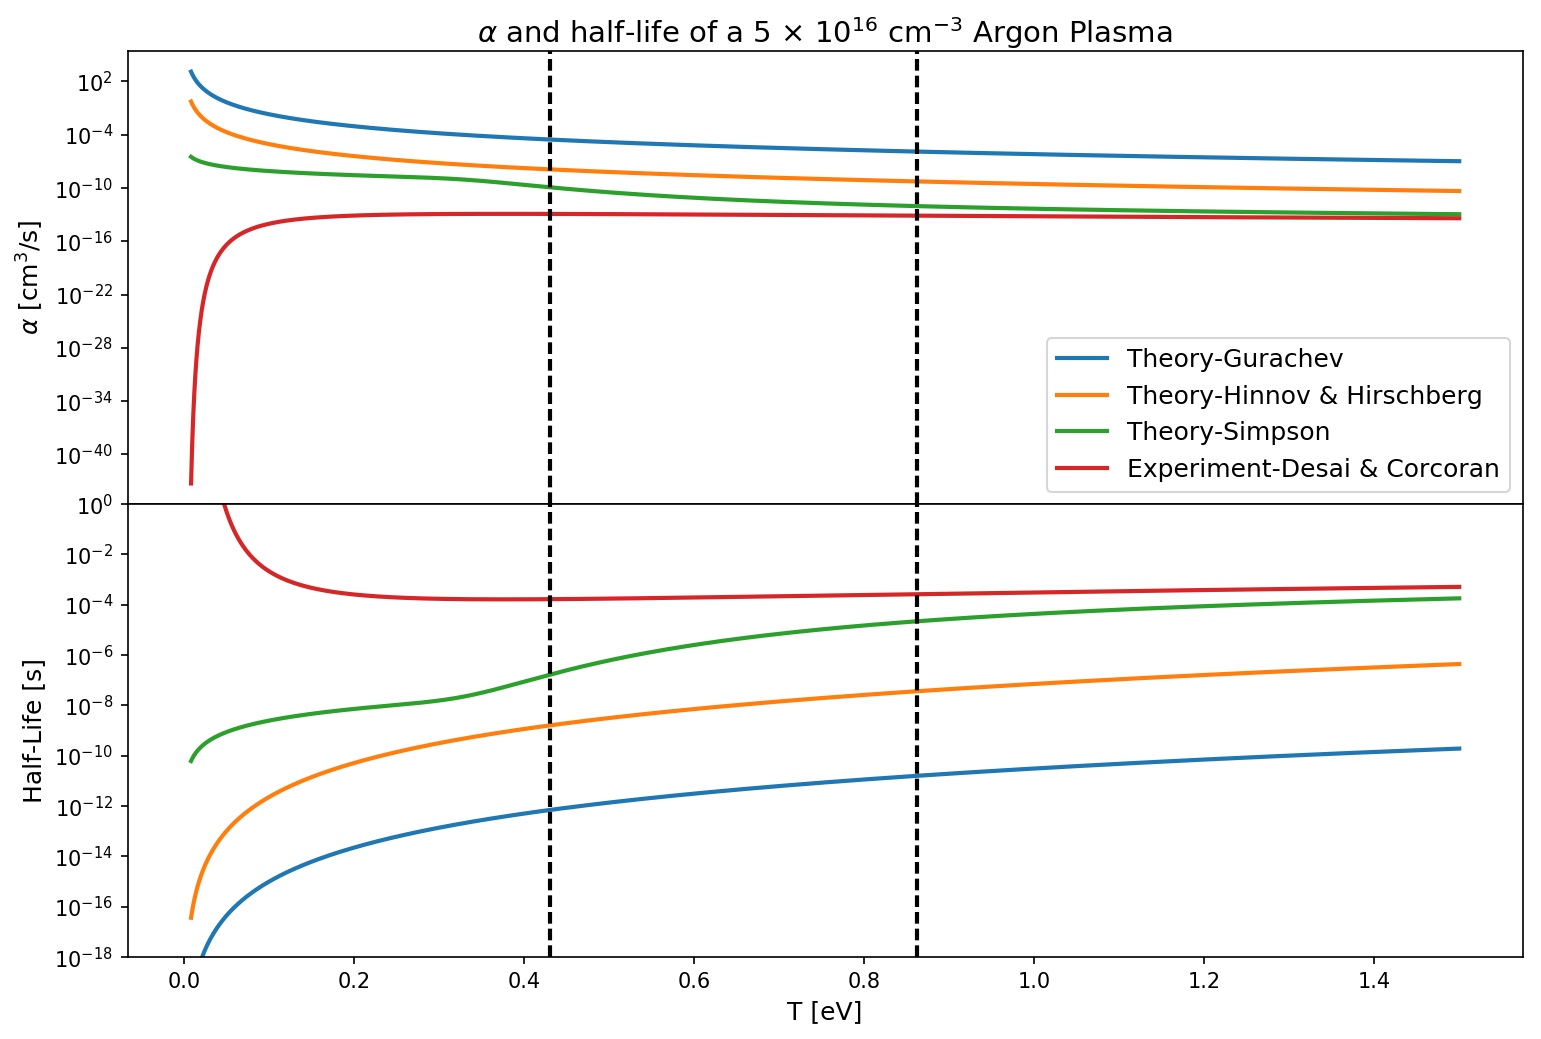

In [5]:
fig = plt.figure(figsize = (12,8), dpi = 150)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.subplots_adjust(hspace = 0.0)
#alpha
ax1.semilogy(T_eV, alpha_g, label = 'Theory-Gurachev')
ax1.semilogy(T_eV, alpha_hh, label = 'Theory-Hinnov & Hirschberg')
ax1.semilogy(T_eV, alpha_s, label = 'Theory-Simpson')
ax1.semilogy(T_eV, alpha_d, label = 'Experiment-Desai & Corcoran')
# half-life
ax2.semilogy(T_eV, t_g)
ax2.semilogy(T_eV, t_hh)
ax2.semilogy(T_eV, t_s)
ax2.semilogy(T_eV, t_d)

ax1.set_ylabel('$\\alpha$ [cm$^3$/s]')
ax1.legend()
ax1.set_title('$\\alpha$ and half-life of a 5 $\\times$ 10$^{16}$ cm$^{-3}$ Argon Plasma')
ax1.set_xticks([])
ax2.set_ylabel('Half-Life [s]')
ax2.set_xlabel("T [eV]")
ax2.set_ylim([1e-18, 1e0])

ax1.axvline(x = 5000/11600, ls = '--', color = 'k')
ax1.axvline(x = 10000/11600, ls = '--', color = 'k')
ax2.axvline(x = 5000/11600, ls = '--', color = 'k')
ax2.axvline(x = 10000/11600, ls = '--', color = 'k')
plt.savefig(figpath + '3_body_and_half_life.svg')
plt.show()

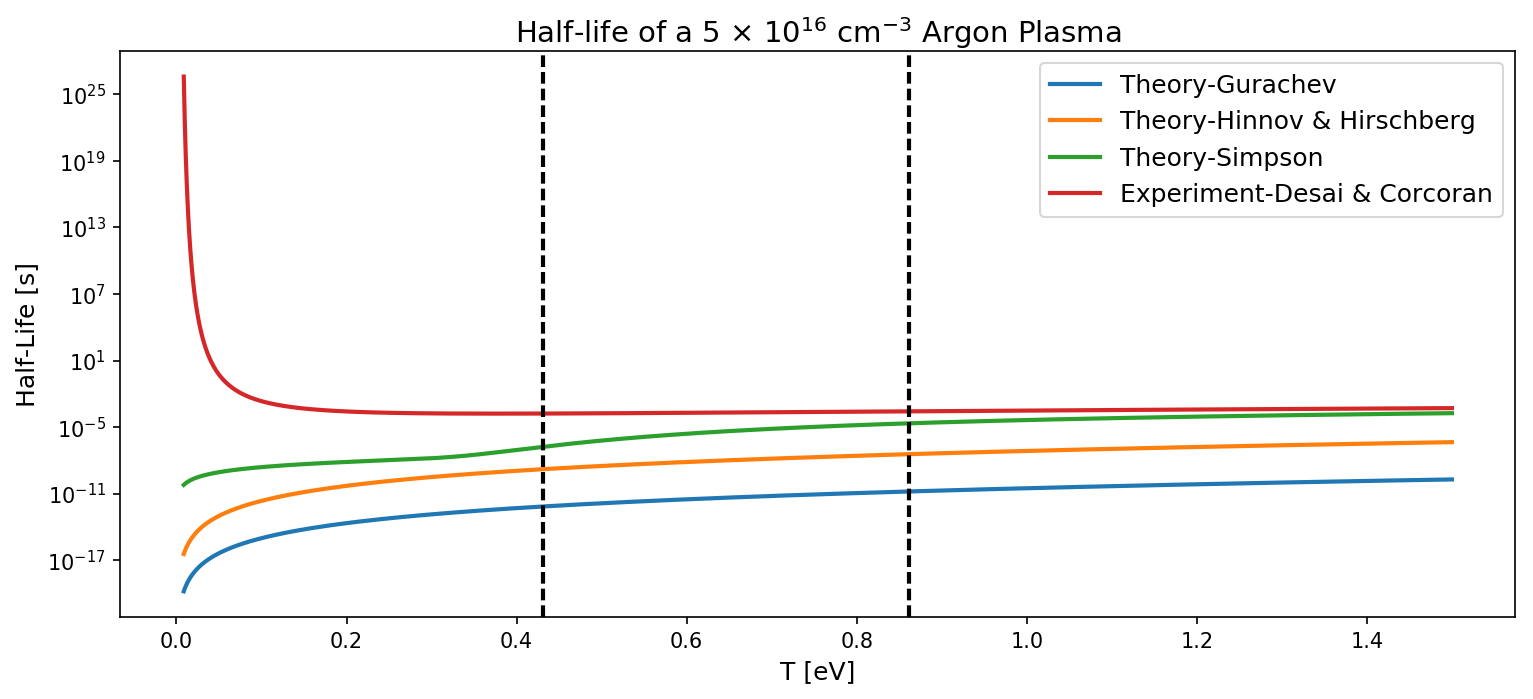

In [6]:
fig = plt.figure(figsize = (12,5), dpi = 150)
ax = fig.gca()




ax.semilogy(T_eV, t_g, label = 'Theory-Gurachev')
ax.semilogy(T_eV, t_hh, label = 'Theory-Hinnov & Hirschberg')
ax.semilogy(T_eV, t_s, label = 'Theory-Simpson')
ax.semilogy(T_eV, t_d, label = 'Experiment-Desai & Corcoran')
ax.axvline(x = 5000/11600, ls = '--', color = 'k')
ax.axvline(x = 10000/11600, ls = '--', color = 'k')

ax.set_ylabel('Half-Life [s]')
ax.set_xlabel("T [eV]")
ax.legend()
ax.set_title('Half-life of a 5 $\\times$ 10$^{16}$ cm$^{-3}$ Argon Plasma')

plt.show()

In [9]:
# Bonus Slides: Maximum Ionization Fraction vs. Beta
beta_s = np.linspace(5e-3, 1, 100)
beamParams = eb.get_beam(beta_s = beta_s)
pos = eb.get_pos(beamParams, nxi = 5)
Er, dum, dum1 = eb.rad_E_field(pos, beamParams)
W_Ar1 = eb.ionization_rate(Er, 'Ar+')
W_Ar2 = eb.ionization_rate(Er, 'Ar2+')
W_He1 = eb.ionization_rate(Er, 'He+')
W_He2 =  eb.ionization_rate(Er, 'He2+')

In [11]:
dum, max_frac_Ar1 = eb.ionization_frac(W_Ar1, pos, beamParams)
dum, max_frac_Ar2 = eb.ionization_frac(W_Ar2, pos, beamParams)
dum, max_frac_He1 = eb.ionization_frac(W_He1, pos, beamParams)
dum, max_frac_He2 = eb.ionization_frac(W_He2, pos, beamParams)

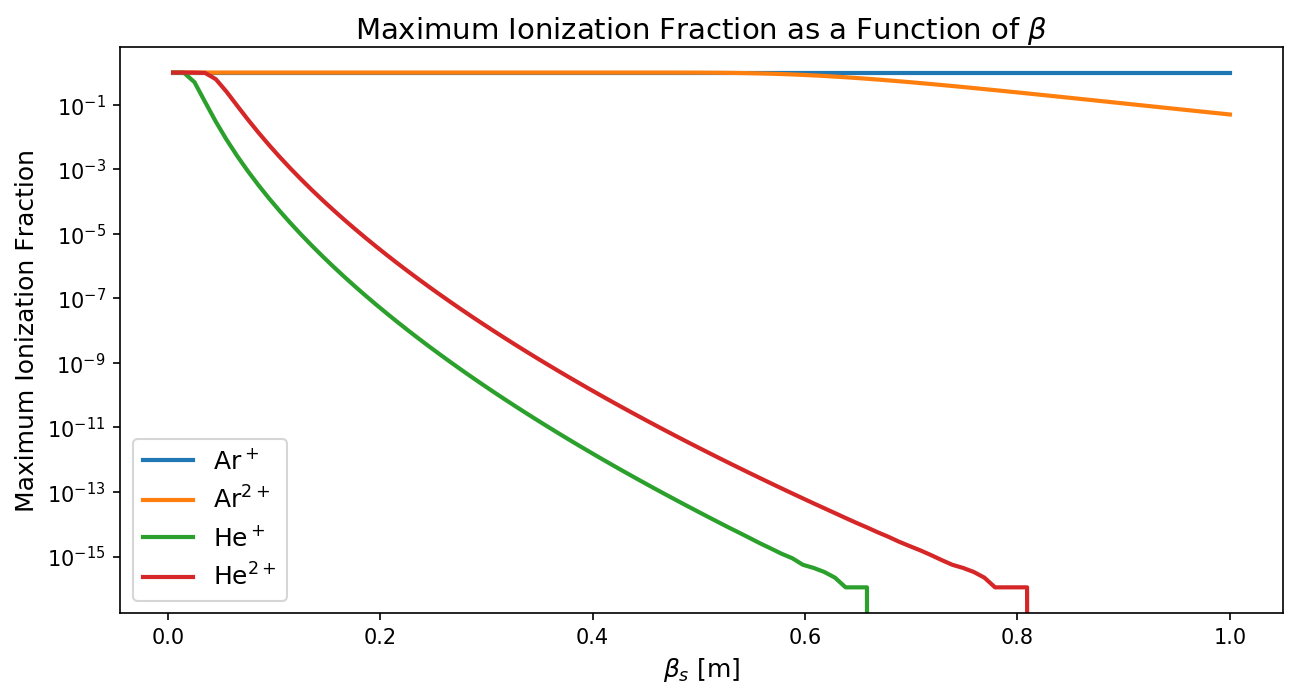

In [20]:
fig = plt.figure(figsize = (10,5), dpi = 150); ax = fig.gca()
ax.plot(beta_s, max_frac_Ar1, label = r'Ar$^+$')
ax.plot(beta_s, max_frac_Ar2, label = r'Ar$^{2+}$')
ax.plot(beta_s, max_frac_He1, label = r'He$^+$')
ax.plot(beta_s, max_frac_He2, label = r'He$^{2+}$')
ax.set_xlabel('$\\beta_s$ [m]')
ax.set_ylabel('Maximum Ionization Fraction')
ax.legend()
ax.set_title('Maximum Ionization Fraction as a Function of $\\beta$')
ax.set_yscale('log')
plt.savefig(figpath + 'ion_frac_v_beta.svg')
plt.show()

In [26]:
# Maximum ionazation rate for a given beta (facet II) varying sigma_z
sigma_zz = np.linspace(5e-6, 20e-6, 100);
sigma_rz = 5e-6;
sigma_tz = beamParams['sigma_z'] / (beamParams['beta'] * c); 
bp = {'sigma_r': sigma_rz, 'sigma_z':sigma_zz, 'sigma_t':beamParams['sigma_t'],
      'charge':1.5e-9, 'beta':beamParams['beta']
     }
rz = np.linspace(-10*sigma_rz, 10*sigma_rz, 1000)
xiz = np.zeros((len(sigma_zz), 1000))
for i in range(len(sigma_zz)):
    xiz[i][:] = np.linspace(-2*sigma_zz[i], 2*sigma_zz[i], 1000)
p = {'r':rz, 'xi':xiz}
Erz, rzPeak, EzPeak = eb.rad_E_field__sigma_z(p, bp)

In [28]:
Wz_Ar1 = eb.ionization_rate(Erz, 'Ar+')
Wz_Ar2 = eb.ionization_rate(Erz, 'Ar2+')
Wz_He1 = eb.ionization_rate(Erz, 'He+')
Wz_He2 = eb.ionization_rate(Erz, 'He2+')
max_Ar1 = eb.ionization_frac_sigma_z(Wz_Ar1, p, bp)
max_Ar2 = eb.ionization_frac_sigma_z(Wz_Ar2, p, bp)
max_He1 = eb.ionization_frac_sigma_z(Wz_He1, p, bp)
max_He2 = eb.ionization_frac_sigma_z(Wz_He2, p, bp)

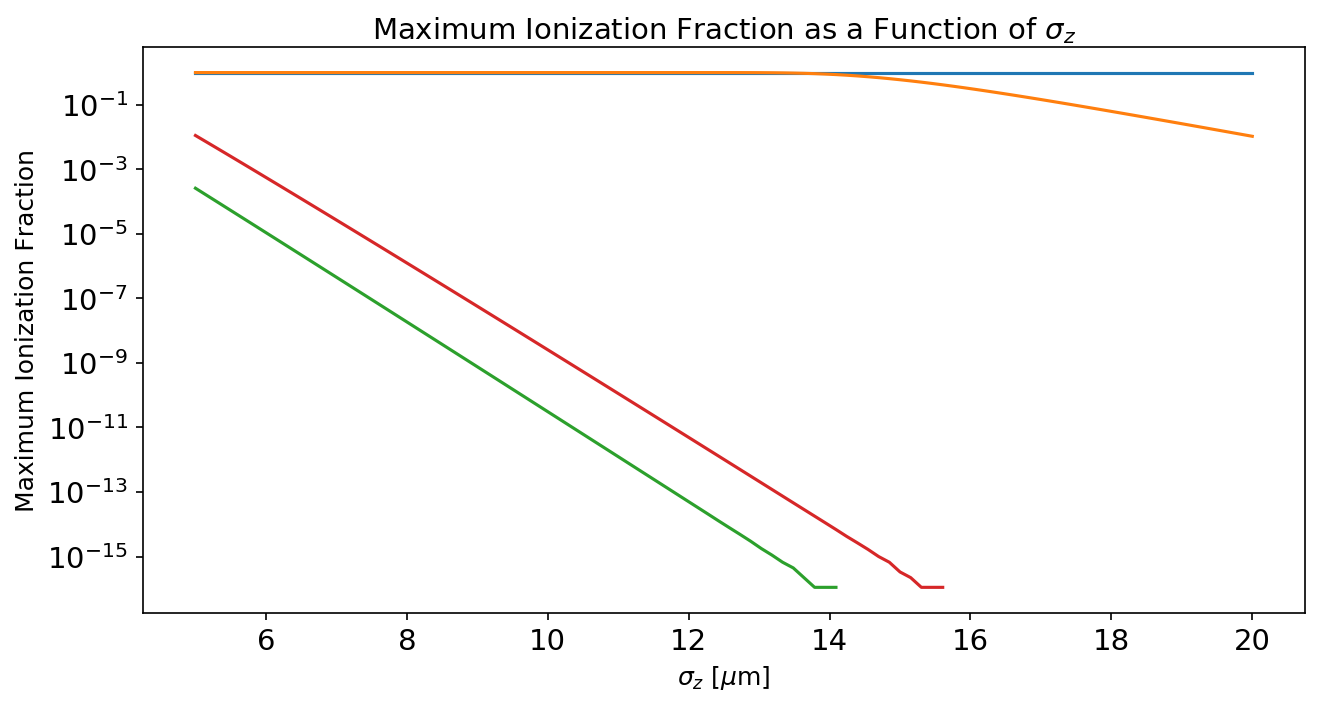

In [35]:
fig = plt.figure(figsize = (10,5), dpi = 150); ax = fig.gca()
ax.semilogy(sigma_zz*1e6, max_Ar1, linewidth = 1.5, label = r'Ar$^{+}$')
ax.semilogy(sigma_zz*1e6, max_Ar2, linewidth = 1.5, label = r'Ar$^{2+}$')
ax.semilogy(sigma_zz*1e6, max_He1, linewidth = 1.5, label = r'He$^{+}$')
ax.semilogy(sigma_zz*1e6, max_He2, linewidth = 1.5, label = r'He$^{2+}$')
ax.set_xlabel(r'$\sigma_z$ [$\mu$m]')
ax.set_ylabel('Maximum Ionization Fraction')
ax.tick_params('both', labelsize = 14)
ax.set_title('Maximum Ionization Fraction as a Function of $\sigma_z$')
plt.savefig(figpath + 'ion_frac_v_sigma_z.svg')
plt.show()